# CMSC 33750 HW4
## Lynn Zheng
## 11/7/20

Code files: (Note: `p#` stands for part `#` of the assignment)
- `hw4_eval.ipynb`: this notebook, contains visualization code and writeup
- `preprocess_data.py`: script for saving provided `normal-tumor, type-class` datat files to `.npy` files for faster loading
- `p1_generate_data.py`: generate data for part 1 for retraining the TC classifier
- `train.py`: training script for part 1, 2, 4; run using `train.py [p1|p2|p4]`
- `p4_preprocess_data.ipynb`: process `normal, tumor, metadata` data for training the classifier in part 4
- `p6_train.py`: Variational Autoencoder training script for part 6
- `train.sh, p6_train.sh`: slurm sbatch script
- `logs/`: model training logs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from IPython.display import display

from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [2]:
from train import load_data_concat_normal, construct_model

In [3]:
# plotting utils
def plot_confusion_matrix(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True labels')
    return ax

def plot_accu_loss(logfile):
    log = pd.read_csv(logfile)
    accu_df = log.melt('epoch', value_vars=['accuracy', 'val_accuracy'])
    loss_df = log.melt('epoch', value_vars=['loss', 'val_loss'])
    df = pd.concat([accu_df.assign(plot='accuracy'), loss_df.assign(plot='loss')])
    g = sns.FacetGrid(df, col='plot', hue='variable', sharey=False)
    g.map_dataframe(sns.lineplot, x='epoch', y='value')
    g.add_legend()
    plt.show()

# P1

In [4]:
tc_test = np.load('data/tc_test.npy')
tc_test_labels = np.load('data/tc_test_labels.npy')

In [6]:
p1_model = construct_model(tc_test.shape[1], tc_test_labels.shape[1], 
                           weights='models/p1.autosave.model.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 60464, 128)        2688      
_________________________________________________________________
activation_5 (Activation)    (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 60464, 128)        0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60455, 128)        163968    
_________________________________________________________________
activation_6 (Activation)    (None, 60455, 128)        0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6045, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 773760)           

In [7]:
score = p1_model.evaluate(tc_test, tc_test_labels, verbose=0)
score

[0.13593116402626038, 0.970370352268219]

In [8]:
probs = p1_model.predict(tc_test, verbose=0)

In [9]:
preds = np.argmax(probs, axis=1)
true_labels = np.argmax(tc_test_labels, axis=1)

In [10]:
print(np.unique(preds))
print(np.unique(true_labels))

[ 1  3  4  5  6  8 11 14 15 16 17 18 22 25 29 30 33 35]
[ 1  3  4  5  6  8 11 14 15 16 17 18 22 25 29 30 33 35]


In [25]:
cf_matrix = confusion_matrix(true_labels, preds)

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

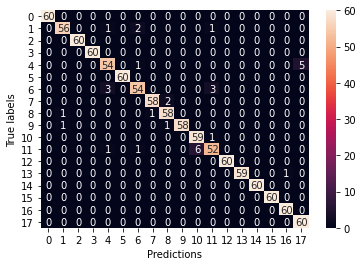

In [60]:
# although there are 36 classes in total in the code, 
# there are only 17 classes in the allocated tc_test data
plot_confusion_matrix(cf_matrix)

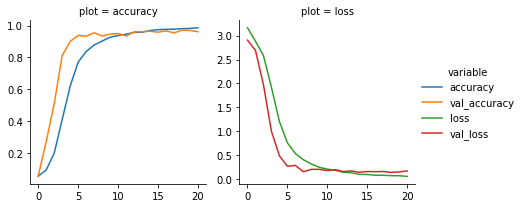

In [51]:
# epoch on the x-axis
plot_accu_loss('logs/p1.training.log')

# P1 Writeup
I used `type-class/tc1.autosave.model.h5` to generate tumor type classification labels for the tumor samples from the NT train and test dataset. (For the ease of data organization, I generated labels for the entire dataset, including tumor and normal, but only pulled out the tumor data for use.) I retrained the type classifier on `tc_train + tc_train_labels, nt_train + nt_train_tc_labels, nt_test + nt_test_tc_labels` (NT datasets with generated TC labels). I tested the model using `tc_test + tc_test_labels`.

Due to computation resource limitations, I could only train the model for 20 epochs. However, it still performed decently and achieved a test error of 0.136, and an accuracy of 0.97. 

From the confusion matrix above, the only prominent point of confusion is when the classifier recognizes 5 datapoints belonging to class 4 as class 17.

From the loss and accuracy above, we observe that the train and validation losses are steadily decreasing and the train and loss accuracy is steadily improving.

# P2

In [ ]:
_, _, X_test, Y_test = load_data_concat_normal()

In [ ]:
p2_model = construct_model(X_test.shape[1], Y_test.shape[1], 
                           weights='models/p2.autosave.model.h5')

In [ ]:
score = p2_model.evaluate(X_test, Y_test, verbose=0)
score

In [67]:
probs = p2_model.predict(X_test, verbose=0)

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

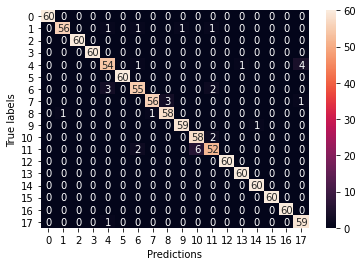

In [68]:
preds = np.argmax(probs, axis=1)
true_labels = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(true_labels, preds)
plot_confusion_matrix(cf_matrix)

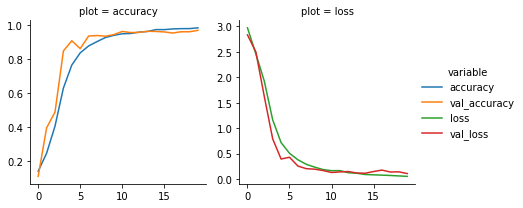

In [69]:
# epoch on the x-axis
plot_accu_loss('logs/p2.training.log')